In [1]:
%load_ext autoreload

In [60]:
#imports
%autoreload 2
import os
os.chdir('/home/kitouni/projects/Geometric-HEP/pythia-gen/')
import pandas as pd
import flow
from flow import LightningModel, PTLoss, EFNLocal, EFNHybrid
from flow.utils import mkdir
from flow.utils.data.dataset import  _trim_df
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("dark_paper")


# Load Data


In [57]:
from flow.utils.data.dataset import EICdata
from flow.utils.data.processing import get_loaders
dataset = EICdata(root='./data/EIC/')
train_loader, val_loader = get_loaders(dataset, seed=0, val_split=.1,
                                       n_data=9900, batch_size=32,num_workers=12)

events_breit = pd.read_hdf('data/EIC/raw/breit0.h5', key=f'data')
targets = pd.read_hdf("data/EIC/raw/targets_breit0.h5",key='data').values
scalars = pd.read_hdf("data/EIC/raw/scalars0.h5",key='data').values


# Instantiate network and train


In [61]:
torch.manual_seed(0)
hidden_channels = 128
nn = torch.nn.Sequential(torch.nn.Linear(3+3,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(hidden_channels),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),                                       
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Dropout(0.5),
                         torch.nn.Linear(hidden_channels,1),
                         torch.nn.Sigmoid())

nn2 = torch.nn.Sequential(torch.nn.Linear(3,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(hidden_channels),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Dropout(0.5),
                         torch.nn.Linear(hidden_channels,10))

phi = torch.nn.Sequential(torch.nn.Linear(10,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.BatchNorm1d(hidden_channels),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Linear(hidden_channels,hidden_channels),
                         torch.nn.ReLU(),
                         torch.nn.Dropout(0.5),
                         torch.nn.Linear(hidden_channels,3))

efn = EFNHybrid(local_nn=nn, global_nn=nn2, phi=phi, global_use_scalars=False,
                local_use_scalars=False)
#efn = EFNLocal(nn=nn, use_scalars=False)
optim  = torch.optim.Adam(efn.parameters(),weight_decay=0,lr=1e-5)
module = LightningModel(efn, optim=optim,
               criterion=PTLoss(torch.nn.MSELoss()))

In [62]:
# Run
logdir = "./lightning_logs/segmentation"
mkdir(logdir)
name = "hybrid_phi"
log = flow.utils.Logger(logdir, name=name,default_hp_metric=False)
checkpoint_path = os.path.join(logdir,f"{name}/version_{log.version}")
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_path,filename="weights.cpkt",
                                      save_top_k=1,monitor='val_loss',mode='min')
bar = flow.utils.ProgressBar()
pl.seed_everything(42)
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=200, progress_bar_refresh_rate=1,
                     callbacks=[bar,checkpoint_callback])
trainer.fit(module,train_dataloader=train_loader,val_dataloaders=val_loader)
#readme(checkpoint_path, "")

Missing logger folder: ./lightning_logs/segmentation/hybrid_phi
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | EFNHybrid | 153 K 


Epoch 199: 100%|##########| 558/558 [00:08<00:00, 69.01it/s, loss=0.395, v_num=0, val_loss=0.41] 


1

# Plotting

In [68]:
#get weights
efn.to("cuda:0")
efn.eval()
weights = list()
theta = list()
phi = list()
pt = list()
E = list()
for i in range(len(dataset[:9000])):
    batch = dataset[i]
    batch.to("cuda:0")
    with torch.no_grad():
        weights.append(efn(batch).cpu().numpy())
    theta.append(_trim_df(events_breit,i)['theta'].values)
    phi.append(_trim_df(events_breit,i)['phi'].values)
    pt.append(np.abs(_trim_df(events_breit,i)['pT'].values).sum())
    E.append(_trim_df(events_breit,i)['E'].values)
theta = np.array(theta,dtype='object')
phi = np.array(phi,dtype='object')
E = np.array(E,dtype='object')
weights = np.array(weights,dtype='object')
pt = np.array(pt)

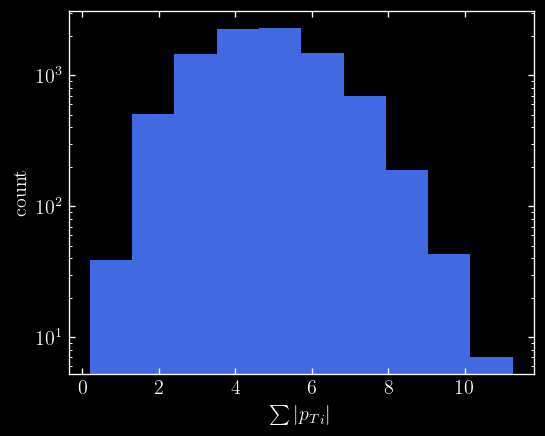

In [69]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
out = plt.hist(pt)
plt.yscale('log')
plt.xlabel(r"$\sum|{p_T}_i|$")
plt.ylabel("count")
plt.show()

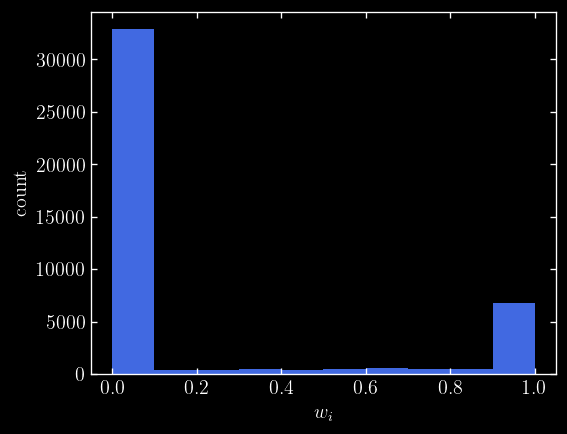

In [70]:
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
plt.hist(np.concatenate(weights[pt>6]).flatten())
#plt.yscale('log')
plt.xlabel(r"$w_i$")
plt.ylabel("count")
plt.show()

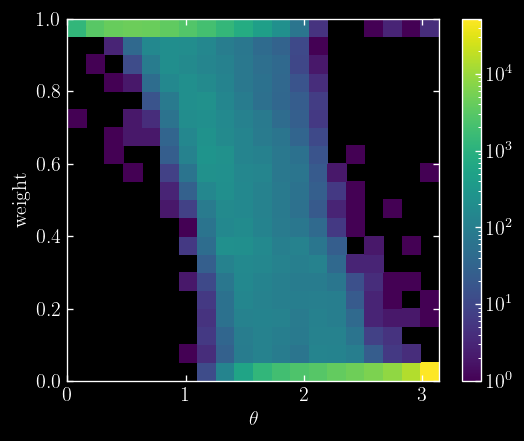

In [71]:
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1,figsize=(5,4), dpi=120)
minpt = 0
theta_ = np.concatenate(theta[pt>minpt]).flatten()
weights_ = np.concatenate(weights[pt>minpt]).flatten()
plt.hist2d(theta_,weights_,bins=20,norm=LogNorm())
plt.xlabel(r"$\theta$")
plt.ylabel("weight")
plt.xlim([0,np.pi])
plt.colorbar()
plt.show()

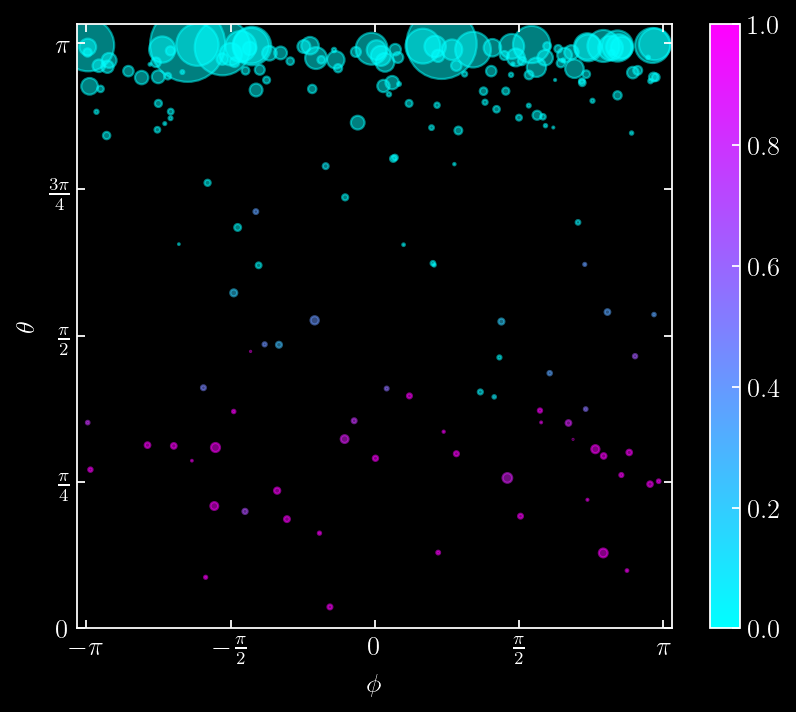

In [72]:
from matplotlib import cm
def build_plot():
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\theta$')
    plt.xlim([-np.pi-0.1,np.pi+0.1])
    plt.ylim([0,np.pi+0.1])
    plt.xticks(ticks=np.linspace(-np.pi,np.pi,5),labels=[r'$-\pi$',r'$-\frac{\pi}{2}$',0,r'$\frac{\pi}{2}$',r'${\pi}$'])
    plt.yticks(ticks=np.linspace(0,np.pi,5),labels=[0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',r'${\pi}$'])
    plt.colorbar(cm.ScalarMappable(cmap=cmap))
    plt.show()

minpt = 10.5
maxpt = 21
cond = (pt>minpt)&(pt<maxpt)
weights_ = np.concatenate(weights[cond]).flatten()
theta_ = np.concatenate(theta[cond]).flatten()
phi_ = np.concatenate(phi[cond]).flatten()
E_ = np.concatenate(E[cond]).flatten()

cmap = cm.cool
colors = cmap(weights_)
fig,ax = plt.subplots(1,1,figsize=(6,5), dpi=160)
plt.scatter(phi_,theta_, alpha = 0.5, s=E_*10, c=colors)
build_plot()


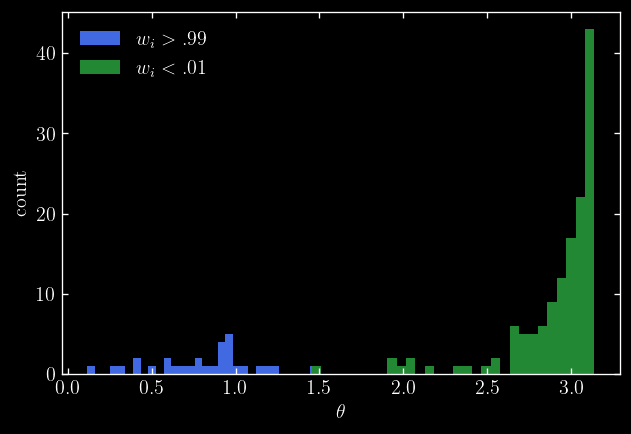

In [73]:
fig,ax = plt.subplots(1,1,figsize=(6,4), dpi=120)
plt.hist(theta_[weights_>.99],label=r'$w_i>.99$',bins=30)
plt.hist(theta_[weights_<.01],label=r'$w_i<.01$',bins=30)
plt.xlabel(r"$\theta$")
plt.ylabel("count")
plt.legend()
plt.show()